In [34]:
import nibabel as nib
import pandas as pd
import numpy as np

from nilearn import datasets

from average_conn_nc import correct_mean_var, build_size_roi, build_combined_mask, _simulate_img, _extract_time_series_voxel, _extract_time_series_parcels, _average_conn

# Load data for this mini experiment

We first get the mask of parcels

In [35]:
parcellation = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale064']
img_mist = nib.load(parcellation)

Fetch a demo dataset

In [36]:
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=True)
imgs = data.func[0:10]
confounds = data.confounds[0:10]  

Build a group mask of fMRI brains for this mini-study

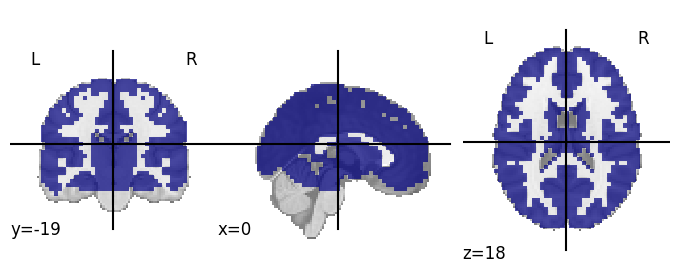

In [38]:
from nilearn.plotting import plot_roi
mask_combined = build_combined_mask(imgs)
plot_roi(mask_combined, resampling_interpolation='nearest')

TODO: explore which MIST regions have small overlap with our mask, and possibly create a custom MIST atlas by excluding those regions 

# Load voxel-wise data for one subject

## This is the way we did it originally

In [76]:
from nilearn.maskers import NiftiMasker
from nilearn.maskers import NiftiLabelsMasker
from nilearn.image import resample_to_img

masker = NiftiMasker(standardize=True, mask_img=mask_combined, smoothing_fwhm=5,
                           memory='nilearn_cache')
time_series_voxel = masker.fit_transform(imgs[0], confounds=confounds[0])

img_n = masker.inverse_transform(time_series_voxel)

mist_resampled = resample_to_img(img_mist, mask_combined, interpolation='nearest')

masker_mist = NiftiLabelsMasker(labels_img=mist_resampled, standardize=False,
                           memory='nilearn_cache')
time_series_mist = masker_mist.fit_transform(img_n)

np.var(time_series_mist, axis=0)

array([0.07189103, 0.12811036, 0.03420185, 0.05506778, 0.        ,
       0.02342861, 0.17162246, 0.04550914, 0.00425407, 0.15318133,
       0.        , 0.0033628 , 0.07158569, 0.08979335, 0.        ,
       0.11121712, 0.10970106, 0.09104467, 0.14820679, 0.17394102,
       0.07931476, 0.00580568, 0.13794761, 0.04471486, 0.03131744,
       0.06162408, 0.12290025, 0.08006804, 0.00158666, 0.18680593,
       0.18172388, 0.11704294, 0.36357799, 0.12457719, 0.21862329,
       0.03547169, 0.16713906, 0.17946227, 0.05937302, 0.16940867,
       0.02960388, 0.07942073, 0.14905921, 0.        , 0.04701981,
       0.10120652, 0.10760563, 0.        , 0.14838123, 0.05840484,
       0.12042625, 0.08669737, 0.11630356, 0.0736085 , 0.05890693,
       0.07270342, 0.08549519, 0.10115371, 0.1742073 , 0.05906836,
       0.06731174, 0.10887669, 0.0850548 , 0.09072561])

Calculate AFC

In [86]:
var_mist = time_series_mist.var(axis=0) 
var_mist = np.reshape(var_mist, [var_mist.shape[0], 1])
size_parcels = build_size_roi(parcels_voxel, masker_parcels.labels_)
mask_empty = (size_parcels == 0) | (size_parcels == 1)
afc = ((size_parcels * size_parcels) * var_mist - size_parcels) / (size_parcels * (size_parcels - 1))
afc[mask_empty] = 0

/var/folders/dt/mwxrt1s120l7rg9b1ty2pc540000gn/T/ipykernel_25786/3297889255.py:5: RuntimeWarning: invalid value encountered in divide
  afc = ((size_parcels * size_parcels) * var_mist - size_parcels) / (size_parcels * (size_parcels - 1))


In [87]:
num_parcel = 1
print(f"parcel number {num_parcel}, average connectivity {afc[num_parcel - 1]}, size {size_parcels[num_parcel - 1]}")

parcel number 1, average connectivity [0.0690087], size [323.]


# This is when I do it using the function(s) we later wrote

In [77]:
time_series_parcels, masker_parcels, parcels_voxel = _extract_time_series_parcels(imgs[0], mask_combined, img_mist)

Compute AFC

In [88]:
var_mist = time_series_parcels.var(axis=0) 
var_mist = np.reshape(var_mist, [var_mist.shape[0], 1])
size_parcels = build_size_roi(parcels_voxel, masker_parcels.labels_)
mask_empty = (size_parcels == 0) | (size_parcels == 1)
afc = ((size_parcels * size_parcels) * var_mist - size_parcels) / (size_parcels * (size_parcels - 1))
afc[mask_empty] = 0

/var/folders/dt/mwxrt1s120l7rg9b1ty2pc540000gn/T/ipykernel_25786/1419502543.py:5: RuntimeWarning: invalid value encountered in divide
  afc = ((size_parcels * size_parcels) * var_mist - size_parcels) / (size_parcels * (size_parcels - 1))


In [89]:
num_parcel = 1
print(f"parcel number {num_parcel}, average connectivity {afc[num_parcel - 1]}, size {size_parcels[num_parcel - 1]}")

parcel number 1, average connectivity [0.04633498], size [323.]


## Different results!

# Or this function, which combines them all. Same result as above but not as originally

In [90]:
afc, size_parcels = _average_conn(imgs[0], mask_combined, img_mist)

/Users/natashaclarke/ad_sz/scripts/average_conn_nc.py:125: RuntimeWarning: invalid value encountered in divide
  afc = ((size_parcels * size_parcels) * var_parcels - size_parcels) / (size_parcels * (size_parcels - 1))


In [91]:
num_parcel = 1
print(f"parcel number {num_parcel}, average connectivity {afc[num_parcel - 1]}, size {size_parcels[num_parcel - 1]}")

parcel number 1, average connectivity [0.04633498], size [323.]


# 'Brute force' method to compare to, using 1 network only

In [16]:
from nilearn.image import resample_to_img
from nilearn.maskers import NiftiMasker
mist_resampled = resample_to_img(img_mist, mask_combined, interpolation='nearest')
masker_no_standardize = NiftiMasker(standardize=False, mask_img=mask_combined, 
                           memory='nilearn_cache', verbose=5)
parcels_voxel = masker_no_standardize.fit_transform(mist_resampled)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[Memory]0.0s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _filter_and_mask...
_____________________________________filter_and_mask cache loaded - 0.0s, 0.0min


In [17]:
time_series_voxel, masker = _extract_time_series_voxel (imgs[0], mask_combined)

In [93]:
# Extract the voxel time series in the first network
time_series_network = time_series_voxel[:, parcels_voxel[0, :]==num_parcel]
time_series_network.shape

(168, 323)

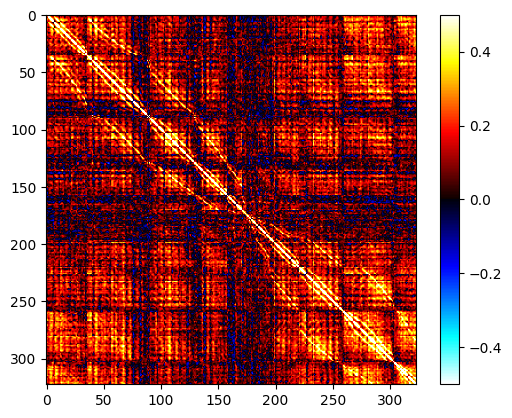

In [94]:
import matplotlib.pyplot as plt
conn_network = np.corrcoef(time_series_network.transpose())
plt.imshow(conn_network, vmin=-0.5, vmax=0.5, cmap='cold_hot')
plt.colorbar()

In [95]:
np.mean(conn_network[np.tril(np.ones(conn_network.shape), -1)==1])

0.10419664303550362

# Not the same as either of the other calculations...

# Test the software

Let's simulate some data with one "spot". Note, time series are random so 'corr' will change!

In [96]:
img, mask, corr = _simulate_img()

In [97]:
corr

0.7159254791031221

## Step 1: Let's compute AFC brute force

In [98]:
time_series_voxel, masker_voxel = _extract_time_series_voxel(imgs[0], mask_combined)

In [99]:
assert abs(np.corrcoef(time_series_voxel.transpose())[1, 0] - corr) < 1e-10

AssertionError: 

## Step 2: use the super complicated method

Using a little function to compute AFC, to make life easier.

In [63]:
time_series_parcels, masker_parcels, parcels_voxel = _extract_time_series_parcels(img, mask, mask)
assert np.abs(np.var(time_series_parcels) - (1 + 1 + 2 * corr) / 4) < 1e-10

In [64]:
afc_test = _average_conn(img, mask, mask)
assert np.abs(corr - afc_test) < 1e-10

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [100]:
afc_test

(array([[0.78475544]]), array([[2.]]))

## It works, bar rounding differences!

# Now we compute the connectome and add the afc as the diagonal

Compute connectome

In [31]:
from nilearn.connectome import ConnectivityMeasure
corr_measure = ConnectivityMeasure(kind="correlation")
connectome = corr_measure.fit_transform([time_series_mist])[0]
connectome.shape

(64, 64)

Get the indices of the diagonal

In [32]:
diagonal = np.diag_indices_from(connectome)

Flatten the afc array

In [33]:
afc_flat = afc.flatten()
afc_flat.shape

(64,)

And replace the connectome diagonal with the afc values

In [34]:
connectome[diagonal] = afc_flat
connectome

array([[ 0.0690087 ,  0.31120011,  0.17902712, ...,  0.07354644,
         0.10012176,  0.25170663],
       [ 0.31120011,  0.12349719,  0.23447292, ...,  0.20959206,
        -0.01253303,  0.14484275],
       [ 0.17902712,  0.23447292,  0.02704779, ...,  0.18892664,
         0.00969686,  0.35252661],
       ...,
       [ 0.07354644,  0.20959206,  0.18892664, ...,  0.10641502,
         0.35507157,  0.37854513],
       [ 0.10012176, -0.01253303,  0.00969686, ...,  0.35507157,
         0.08254122,  0.49470753],
       [ 0.25170663,  0.14484275,  0.35252661, ...,  0.37854513,
         0.49470753,  0.08910191]])

## Finally, we fisher-z transform the connectome values, to match NIAK

In [35]:
connectome_fisher = np.arctanh(connectome) 

Convert to a dataframe

In [36]:
connectome_df = pd.DataFrame(connectome_fisher, columns=masker_mist.labels_, index=masker_mist.labels_)
connectome_df.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0
1.0,0.069119,0.321874,0.180977,0.528922,0.0,0.307549,0.427502,0.430011,0.009980,0.352647,...,0.195776,0.393153,0.081296,0.125596,0.069289,0.457091,0.099971,0.073679,0.100458,0.257234
2.0,0.321874,0.124131,0.238917,0.384386,0.0,0.293819,0.535912,0.276371,-0.000654,0.241855,...,0.029979,0.212758,0.004852,0.016117,0.043604,0.600502,-0.029318,0.212745,-0.012534,0.145869
3.0,0.180977,0.238917,0.027054,0.299724,0.0,0.555189,0.086204,0.129433,0.007463,0.112383,...,0.016583,0.144450,0.126917,0.029805,0.385439,0.290840,0.057685,0.191224,0.009697,0.368326
4.0,0.528922,0.384386,0.299724,0.051922,0.0,0.416597,0.241703,0.311853,-0.083227,0.205564,...,0.075915,0.303934,0.169206,0.089722,0.402198,0.529603,0.033065,0.285460,0.141915,0.400096
5.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


And save!

In [37]:
from pathlib import Path
connectome_df.to_csv(Path("__file__").resolve().parents[1] / 'data' / 'connectome.csv')

# Something weird going on with some regions?